
Simulate forcing ACL pathway in the NP11 model.And observe what happens with XPK. 
* You can  make a graph with flux of PKETF_c (phosphoketolase (fructose 6-phosphate)) on y axis and ACL on x axis, if you do forcing simulations in few steps. You will obtain like a linear line. 
* FBA params: I suggest Glc max at 0.05 GR and another round for 0.3 GR. 
* And extract cofactor balances, and compare how it changes when ACL is forced to have a flux. Especially NADH.



In [30]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
# os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
# import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt


In [31]:
# NGAM min
model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")
model1.objective = 'r_4046' # NGAM
solution1 = model1.optimize('minimize')
all_fluxes = solution1.fluxes.to_frame(name='Flux')


In [34]:
glucose_uptakes = [0.476, 1.114, 1.648, 2.305, 3.1] 
growth_rates =  [0.03070, 0.08340, 0.12751, 0.1817, 0.24744] # computed when model is optimized for biomass growth and glc uptake is constrained - original: #[0.030702, 0.083402, 0.127511, 0.18178, 0.247448]
 
all_fluxes_NGAM_min = pd.DataFrame(columns=['Glucose uptake', 'Growth rate', *all_fluxes.index], index=range(len(glucose_uptakes))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(glucose_uptakes)):
    print(i)
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")
    model.reactions.r_4041.bounds = growth_rates[i], growth_rates[i]
    model.reactions.r_1714.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.objective =  'r_4046' # NGAM
    solution = model.optimize('minimize') #
    all_fluxes_NGAM_min.loc[i] = solution.fluxes[['r_1714', 'r_4041', *all_fluxes.index]].values
    
all_fluxes_NGAM_min

0
1
2
3
4


,Glucose uptake,Growth rate,r_0001,r_0002,r_0003,r_0004,r_0005,r_0006,r_0007,r_0012,...,y300064,y300065,y300066,y300068,y300069,y300070,y300072,y300074,y300075,y300078
0,-0.476,0.0307,0.0,0.0,0.0,0.0,0.033105,0.011058,0.001663,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.114,0.0834,0.0,0.0,0.0,0.0,0.089934,0.03004,0.004518,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.648,0.12751,0.0,0.0,0.0,0.0,0.1375,0.045928,0.006907,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.305,0.1817,0.0,0.0,0.0,0.0,0.195935,0.065447,0.009842,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.1,0.24744,0.0,0.0,0.0,0.0,0.266826,0.089126,0.013403,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Exchange fluxes
exchange_fluxes_table = all_fluxes_NGAM_min[['r_1714', 'r_1992', 'r_1654','r_2060','r_2005', 'r_1672']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table

,D-glucose exchange,oxygen exchange,ammonium exchange,sulphate exchange,phosphate exchange,carbon dioxide exchange
0,-0.476,-1.488312,-0.126158,-0.00261,-0.006738,1.588705
1,-1.114,-2.968575,-0.342734,-0.00709,-0.018322,3.241298
2,-1.648,-4.2075,-0.524005,-0.010839,-0.028014,4.624467
3,-2.305,-5.735366,-0.746699,-0.015446,-0.039919,6.329537
4,-3.1,-7.576677,-1.016846,-0.021035,-0.054356,8.385815


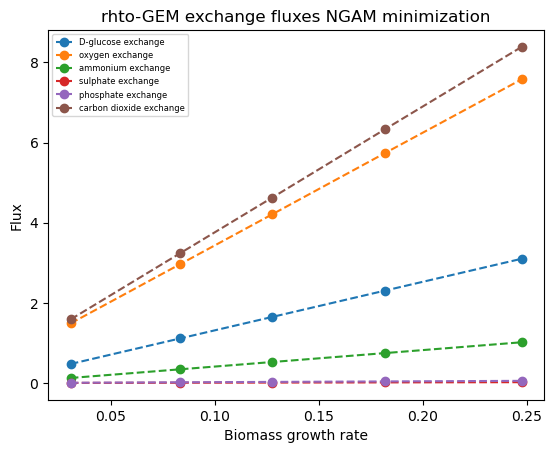

In [36]:
# Exchange fluxes plot

plt.plot(growth_rates, np.abs(exchange_fluxes_table[exchange_fluxes_table.columns]), 'o--', label = exchange_fluxes_table.columns)

plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.title("rhto-GEM exchange fluxes NGAM minimization")
plt.legend(fontsize=6, loc='upper left')
# plt.yticks(range(0, 20, 1))
plt.show()

In [37]:
intracellular_fluxes = all_fluxes_NGAM_min[['r_4041', 'r_1714', 'r_0466', 'r_1049', 'r_1048','r_1050', 't_0081', 'r_0450','r_0959','r_0961', 'r_4046', 'y200003']] # t_0081 - has only one phosphoketolase, not XPK and FPK separately

# Change G6PDH2rp column name to oxpp 

for i in range(len(intracellular_fluxes.columns)):
    intracellular_fluxes = intracellular_fluxes.rename(columns = {intracellular_fluxes.columns[i]: getattr(model.reactions, intracellular_fluxes.columns[i]).name})

intracellular_fluxes = intracellular_fluxes.rename(columns = {'glucose 6-phosphate dehydrogenase': 'oxPPP', 'non-growth associated maintenance reaction': 'NGAM'})
intracellular_fluxes

,biomass pseudoreaction,D-glucose exchange,oxPPP,transketolase 1,transaldolase,transketolase 2,phosphoketolase,fructose-bisphosphate aldolase,pyruvate decarboxylase,pyruvate dehydrogenase,NGAM,ATP-citrate lyase
0,0.0307,-0.476,0.180662,0.041977,-0.232571,0.03678,0.051303,0.0,0.060651,0.464389,3.3928,0.0
1,0.0834,-1.114,0.489495,0.113615,0.0,0.099499,0.139334,0.45357,0.164802,0.901208,3.3928,0.0
2,0.12751,-1.648,0.747269,0.172394,0.172394,0.150812,0.215842,0.81047,0.249149,1.266553,3.3928,0.0
3,0.1817,-2.305,1.064848,0.152573,0.152573,0.121819,0.586833,0.925358,0.075774,1.811153,3.3928,0.0
4,0.24744,-3.1,1.453313,0.337857,0.337857,0.295976,0.412102,1.478156,0.490239,2.264842,3.3928,0.0


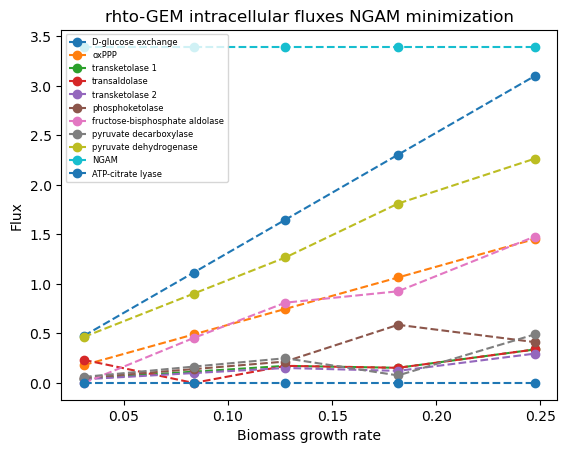

In [38]:
# Plot intracellular fluxes
metabolites = intracellular_fluxes.columns[1:]

x = intracellular_fluxes['biomass pseudoreaction']
y = np.abs(intracellular_fluxes[metabolites])
# Sample data
plt.plot(x, y, 'o--', label= metabolites) #
plt.legend(fontsize=6, loc='upper left')
plt.title("rhto-GEM intracellular fluxes NGAM minimization")
plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.show()

In [23]:
# # Get all fluxes to excel

# with pd.ExcelWriter(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\\NP11_all_fluxes_NGAM_min.xlsx') as excel_writer:
#     all_fluxes_NGAM_min.to_excel(excel_writer, sheet_name='Growth rates 0.05-0.3', index=True)

# #  Get all flux values separately for dif growth rates, make them to a csv file
# for i in range(len(glucose_uptakes)):
# all_fluxes_NGAM_min.loc[0].to_csv(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\NP11_fluxes_NGAM_min_GR_{growth_rates[0]}.csv' , index=True)

COFACTOR BALANCES, when optimized for glc max

In [11]:
# Cofactor lists
nadphs = ['s_1212', 's_1213', 's_1214', 's_1215', 's_2799','s_2952']
nadhs = ['s_1203', 's_1204', 's_1205', 's_1206', 's_1206', 's_3753']
atps = ['s_0434', 's_0435', 's_0437', 's_3881', 's_0438', 's_0439', 's_3359', 's_2840', 's_2831', 's_2856', 's_3341'] 

# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")   
    model.reactions.r_4041.bounds = growth_rates[i], growth_rates[i]
    model.reactions.r_1714.bounds = -9999, 9999
    model.objective = 'r_1714' # glc ex
    solution = model.optimize()

    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title, threshold): # threshold shows the percent of the flux for including in others sector on pie chart 
    import plotly.graph_objects as go
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")   
    model.objective = 'r_1714'
    solution = model.optimize()
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), getattr(model.reactions, reaction).name, str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other producing', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other consuming', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
            
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(title)
    plt.show()  
    
    return pie_chart


In [12]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 5)
nadph_fluxes_highest_GR

# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 0)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 5)
nadh_fluxes_highest_GR

# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 5)
atp_fluxes_highest_GR

SUM produced: 0.6277019343127818, SUM consumed: -0.6277019343127821
SUM produced: 3.855886320756347, SUM consumed: -3.8558863207563467
SUM produced: 4.475523994225022, SUM consumed: -4.475523994225022
SUM produced: 21.05494666920771, SUM consumed: -21.05494666920771
SUM produced: 11.923546175972794, SUM consumed: -11.923546175972799
SUM produced: 54.7230417631872, SUM consumed: -54.7230417631872


,flux,reaction,percent
r_0226,43.793935,r_0226,0.800283
r_0892,4.393387,r_0892,0.080284
r_0962,4.003614,r_0962,0.073161
r_1022,2.284119,r_1022,0.041740
r_0447,0.244375,r_0447,0.004466
...,...,...,...
r_0886,-1.366519,r_0886,0.024972
r_0148,-1.632950,r_0148,0.029840
r_4046,-3.392800,r_4046,0.061999
r_0534,-3.748316,r_0534,0.068496


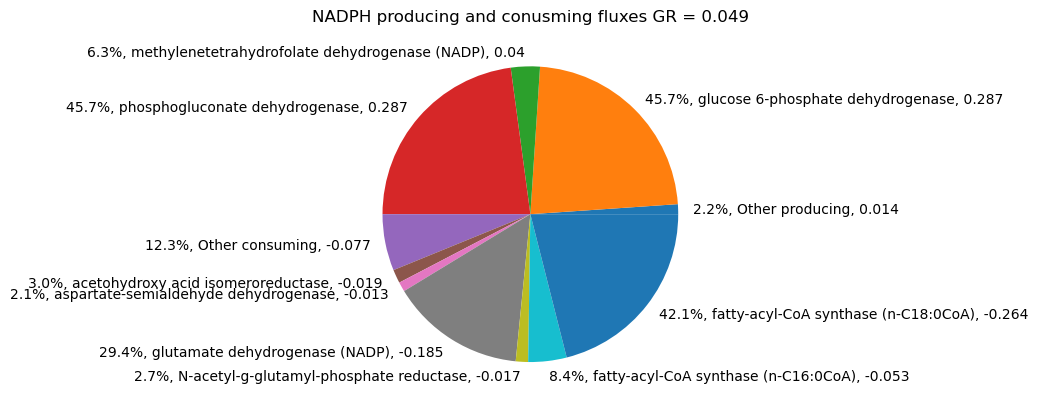

([<matplotlib.patches.Wedge at 0x1e06927eea0>,
 [Text(1.0993634361386855, 0.03741704533153962, '2.2%, Other producing, 0.014'),
  Text(0.7768392989073424, 0.7787943911413006, '45.7%, glucose 6-phosphate dehydrogenase, 0.287'),
  Text(-0.037417061414326, 1.0993634355913047, '6.3%, methylenetetrahydrofolate dehydrogenase (NADP), 0.04'),
  Text(-0.827993124270518, 0.7241735884169945, '45.7%, phosphogluconate dehydrogenase, 0.287'),
  Text(-1.0793843182421623, -0.2119657838730168, '12.3%, Other consuming, -0.077'),
  Text(-0.9978234811483556, -0.46297764575514594, '3.0%, acetohydroxy acid isomeroreductase, -0.019'),
  Text(-0.9578903186458917, -0.5407828930767619, '2.1%, aspartate-semialdehyde dehydrogenase, -0.013'),
  Text(-0.5858806374081597, -0.9309908048472921, '29.4%, glutamate dehydrogenase (NADP), -0.185'),
  Text(-0.06287694587171115, -1.0982014795463746, '2.7%, N-acetyl-g-glutamyl-phosphate reductase, -0.017'),
  Text(0.1280758883248231, -1.0925184514825403, '8.4%, fatty-acyl-CoA

In [13]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'NADPH producing and conusming fluxes GR = {growth_rates[0]}'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold)
producing_nadph_fluxes_lowest_GR_pie_chart


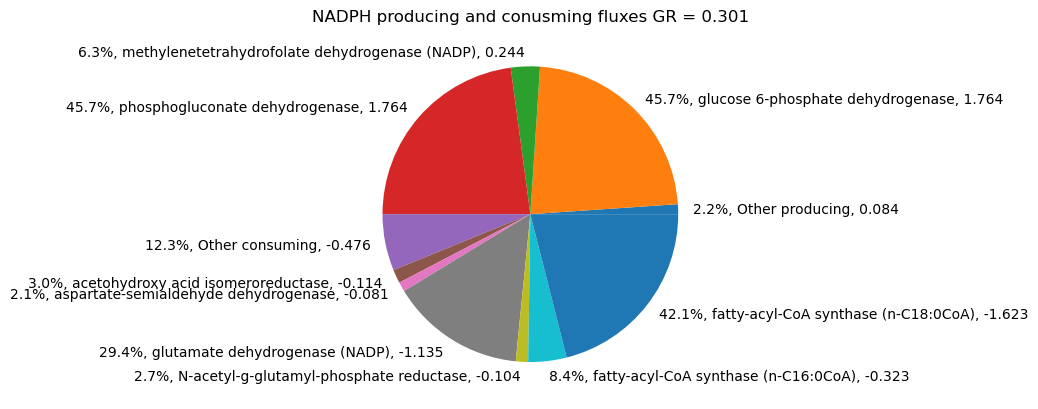

([<matplotlib.patches.Wedge at 0x1e067babb60>,
 [Text(1.0993634371239704, 0.03741701638252397, '2.2%, Other producing, 0.084'),
  Text(0.776839303464592, 0.7787943865954915, '45.7%, glucose 6-phosphate dehydrogenase, 1.764'),
  Text(-0.03741701638252386, 1.0993634371239704, '6.3%, methylenetetrahydrofolate dehydrogenase (NADP), 0.244'),
  Text(-0.8279930691813703, 0.7241736514038706, '45.7%, phosphogluconate dehydrogenase, 1.764'),
  Text(-1.0793842004083363, -0.21196638391230072, '12.3%, Other consuming, -0.476'),
  Text(-0.9978229691101791, -0.4629787493137744, '3.0%, acetohydroxy acid isomeroreductase, -0.114'),
  Text(-0.9578897537849241, -0.5407838936154233, '2.1%, aspartate-semialdehyde dehydrogenase, -0.081'),
  Text(-0.5858796023157048, -0.930991456239203, '29.4%, glutamate dehydrogenase (NADP), -1.135'),
  Text(-0.06287566060862913, -1.0982015531326792, '2.7%, N-acetyl-g-glutamyl-phosphate reductase, -0.104'),
  Text(0.1280770262894304, -1.0925183180784004, '8.4%, fatty-acyl-C

In [14]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'NADPH producing and conusming fluxes GR = {growth_rates[5]}'
producing_nadph_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title, threshold)
producing_nadph_fluxes_highest_GR_pie_chart


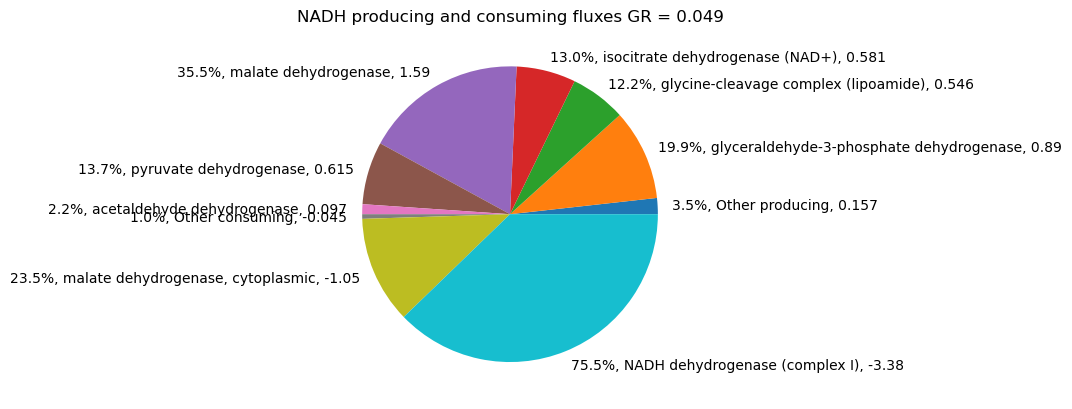

([<matplotlib.patches.Wedge at 0x1e06698ade0>,
 [Text(1.0983262707632393, 0.06065808232474824, '3.5%, Other producing, 0.157'),
  Text(1.00319967783274, 0.4512099360566951, '19.9%, glyceraldehyde-3-phosphate dehydrogenase, 0.89'),
  Text(0.6604446282384762, 0.8796663532447636, '12.2%, glycine-cleavage complex (lipoamide), 0.546'),
  Text(0.27042769306283876, 1.0662405276600169, '13.0%, isocitrate dehydrogenase (NAD+), 0.581'),
  Text(-0.5402020579359511, 0.958218000562379, '35.5%, malate dehydrogenase, 1.59'),
  Text(-1.0560135264681199, 0.307953619748763, '13.7%, pyruvate dehydrogenase, 0.615'),
  Text(-1.099364801558713, 0.0373769058881512, '2.2%, acetaldehyde dehydrogenase, 0.097'),
  Text(-1.099861707164146, -0.017442050165345287, '1.0%, Other consuming, -0.045'),
  Text(-1.0130301024365251, -0.42868404630618506, '23.5%, malate dehydrogenase, cytoplasmic, -1.05'),
  Text(0.4125670857003579, -1.019700151905801, '75.5%, NADH dehydrogenase (complex I), -3.38')])

In [15]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'NADH producing and consuming fluxes GR = {growth_rates[0]}'
producing_nadh_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

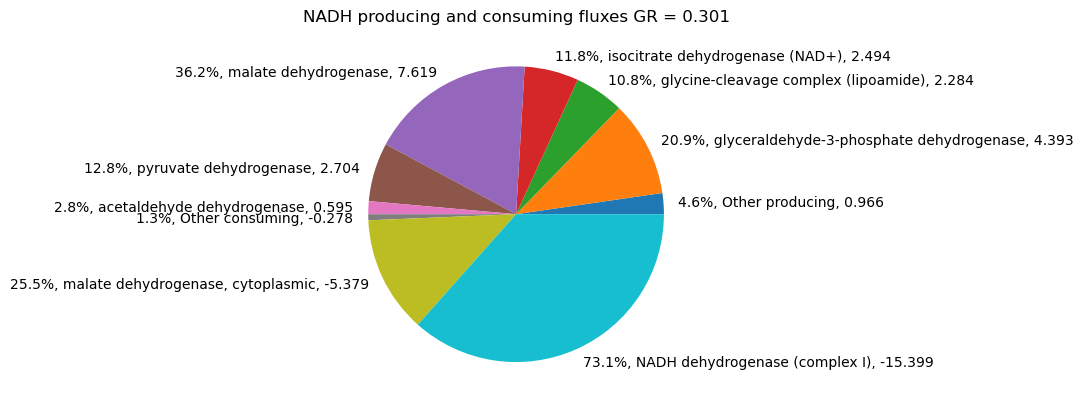

([<matplotlib.patches.Wedge at 0x1e067db3320>,
 [Text(1.09714684294619, 0.07917578552315634, '4.6%, Other producing, 0.966'),
  Text(0.9798030410523204, 0.49998600054864045, '20.9%, glyceraldehyde-3-phosphate dehydrogenase, 4.393'),
  Text(0.6218108542967425, 0.9073870516371475, '10.8%, glycine-cleavage complex (lipoamide), 2.284'),
  Text(0.2660543733914264, 1.0673401849454072, '11.8%, isocitrate dehydrogenase (NAD+), 2.494'),
  Text(-0.5371944415122282, 0.9599073559507528, '36.2%, malate dehydrogenase, 7.619'),
  Text(-1.053922844899086, 0.31503434257207164, '12.8%, pyruvate dehydrogenase, 2.704'),
  Text(-1.0989170610666221, 0.0487984927707615, '2.8%, acetaldehyde dehydrogenase, 0.595'),
  Text(-1.0997642155318974, -0.022774332822507876, '1.3%, Other consuming, -0.278'),
  Text(-0.9939708535781363, -0.4711920439026442, '25.5%, malate dehydrogenase, cytoplasmic, -5.379'),
  Text(0.4505119337336956, -1.003513327048289, '73.1%, NADH dehydrogenase (complex I), -15.399')])

In [16]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'NADH producing and consuming fluxes GR = {growth_rates[5]}'
producing_nadh_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart


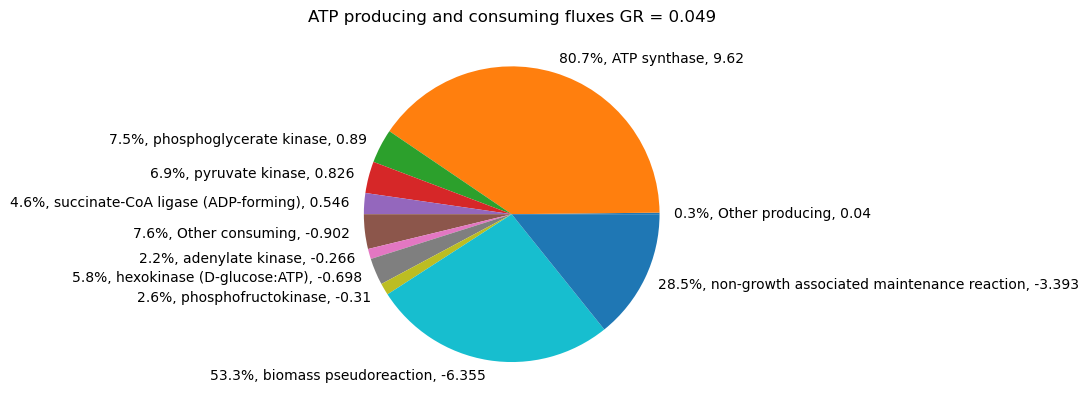

([<matplotlib.patches.Wedge at 0x1e065ef23f0>,
 [Text(1.099984443658814, 0.005850103299068223, '0.3%, Other producing, 0.04'),
  Text(0.31747368334413445, 1.0531906097112282, '80.7%, ATP synthase, 9.62'),
  Text(-0.9762214832818021, 0.50694340471011, '7.5%, phosphoglycerate kinase, 0.89'),
  Text(-1.0650207924394464, 0.275192135918986, '6.9%, pyruvate kinase, 0.826'),
  Text(-1.0971504379746428, 0.07912595308778007, '4.6%, succinate-CoA ligase (ADP-forming), 0.546'),
  Text(-1.0922376992456033, -0.13044848924641167, '7.6%, Other consuming, -0.902'),
  Text(-1.0593346090087163, -0.29632783560838527, '2.2%, adenylate kinase, -0.266'),
  Text(-1.0133086864994405, -0.42802512293646844, '5.8%, hexokinase (D-glucose:ATP), -0.698'),
  Text(-0.9477664677101779, -0.5583356720505797, '2.6%, phosphofructokinase, -0.31'),
  Text(-0.1756550213079842, -1.0858845765040095, '53.3%, biomass pseudoreaction, -6.355'),
  Text(0.9919397961482527, -0.47545287970246125, '28.5%, non-growth associated maintena

In [17]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'ATP producing and consuming fluxes GR = {growth_rates[0]}'
producing_atp_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

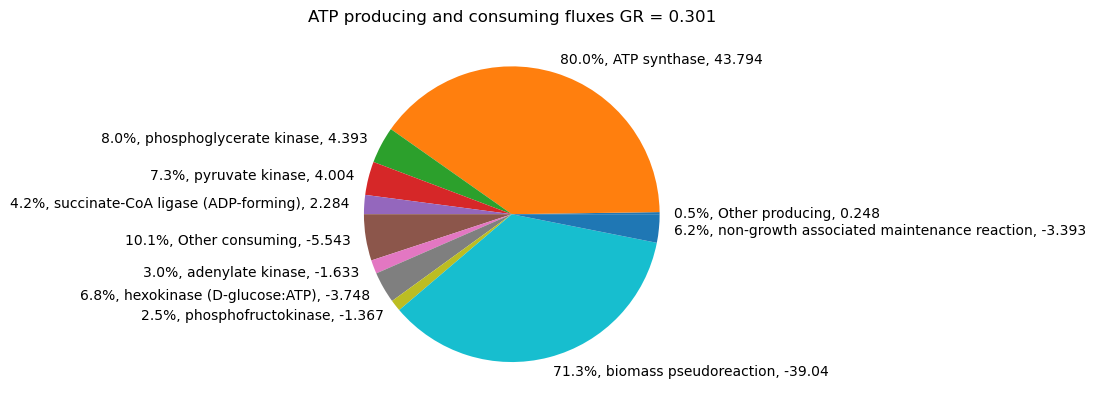

([<matplotlib.patches.Wedge at 0x1e06ba390a0>,
 [Text(1.0999721312206934, 0.007830104584616467, '0.5%, Other producing, 0.248'),
  Text(0.3245231712679442, 1.051039823845984, '80.0%, ATP synthase, 43.794'),
  Text(-0.9720726716198251, 0.5148540774723415, '8.0%, phosphoglycerate kinase, 4.393'),
  Text(-1.0668702242177261, 0.26793268684059224, '7.3%, pyruvate kinase, 4.004'),
  Text(-1.0976365791606941, 0.07206899533370428, '4.2%, succinate-CoA ligase (ADP-forming), 2.284'),
  Text(-1.0861069204359024, -0.17427494765812057, '10.1%, Other consuming, -5.543'),
  Text(-1.0275058685206837, -0.3927234270521118, '3.0%, adenylate kinase, -1.633'),
  Text(-0.9548504871589257, -0.5461323531639216, '6.8%, hexokinase (D-glucose:ATP), -3.748'),
  Text(-0.8646830260636155, -0.6799435744511959, '2.5%, phosphofructokinase, -1.367'),
  Text(0.2779014174406961, -1.0643170590498172, '71.3%, biomass pseudoreaction, -39.04'),
  Text(1.0947876740330997, -0.10695769624106383, '6.2%, non-growth associated mai

In [18]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'ATP producing and consuming fluxes GR = {growth_rates[5]}'
producing_atp_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [19]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\NP11\\NP11_cofactor_fluxes.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[0]}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[5]}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[0]}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[5]}', index=False)
#     atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[0]}', index=False)
#     atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[5]}', index=False)
